Title:

Name:

UW Email:

# Abstract

TODO


# Team members & contributions

TODO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.datasets as datasets
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [3]:
# TODO: create more datasets

UNLABELLED = -1

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_valid = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def generate_indices(dataset, pct_labelled):
    num_samples = int(0.1 * len(dataset))
    return torch.randperm(len(dataset))[:num_samples]

indices_10 = generate_indices(cifar_train, 0.1)

# Define datasets for fully supervised learning

full_dataset_10 = torch.utils.data.Subset(cifar_train, indices_10)
full_loader_10 = DataLoader(full_dataset_10, batch_size=128, shuffle=True, num_workers=2)

loader_valid = DataLoader(cifar_valid, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 78973201.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # initialize weights to make training easier (via transfer learning)
        self.model.fc = nn.Identity()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        features = self.model(x)
        x = self.fc(features)
        return x, features

# Supervised learning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

full_model_10 = Model()

full_model_10.train()
full_model_10.to(device)

optimizer = torch.optim.SGD(full_model_10.parameters(), lr=0.0001, momentum=0.9)
num_epochs = 5

losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm(full_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = full_model_10(images)

        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



  0%|          | 0/40 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:15<00:00,  3.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


Epoch 1/10, Loss: 2.3538


100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Epoch 2/10, Loss: 2.1860


100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


Epoch 3/10, Loss: 1.8731


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


Epoch 4/10, Loss: 1.5780


100%|██████████| 40/40 [00:15<00:00,  2.58it/s]

Epoch 5/10, Loss: 1.4918


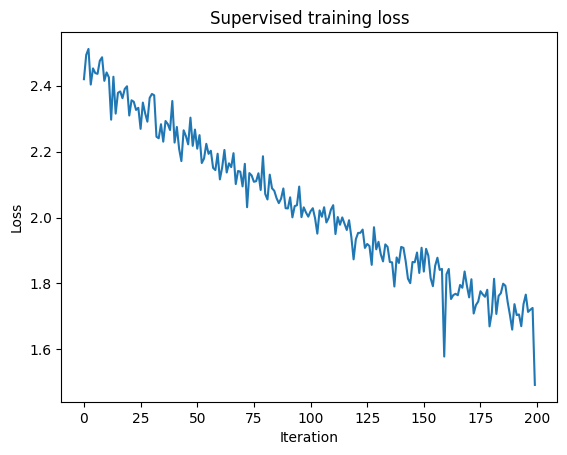

In [ ]:
plt.plot(losses)
plt.title('Supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [ ]:
# TODO: make this its own function maybe (e.g. evaluate_model)?

# Evaluate the model
full_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = full_model_10(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the supervised trained model: %d %%' % (100 * correct / total))


Accuracy of the supervised trained model: 49 %


In [ ]:
# Compared to untrained model

untrained_model = Model()
untrained_model.eval()
untrained_model.to(device)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = untrained_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of an untrained model : %d %%' % (100 * correct / total))


Accuracy of an untrained model : 10 %


# Semi-supervised learning

In [5]:
# Custom dataset for semi-supervised learning
class SemiSupervised(torch.utils.data.Dataset):
    def __init__(self, labeled_dataset, indices):
        self.labeled_dataset = labeled_dataset
        self.labeled_indices = indices

    def __getitem__(self, index):
        if index in self.labeled_indices:
            return self.labeled_dataset[index]
        else:
            img, label = self.labeled_dataset[index]
            return img, UNLABELLED

    def __len__(self):
        return len(self.labeled_dataset)

# Create semi-supervised datasets
semi_dataset_10 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_10
)

semi_loader_10 = DataLoader(semi_dataset_10, batch_size=128, shuffle=True, num_workers=2)

In [6]:
# non-parametric softmax operation by Wu et. al.
# axis 0: v, axis 1: i
def PIV(features, temp):
  upper = torch.exp(torch.matmul(features, features.T) / temp)
  denom = upper.sum(axis=1)
  return upper / denom

def weighted_knn(features, labels, k, temp):
  # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    # Find the k nearest neighbors for each point in x
    _, indices = torch.topk(distances, k=min(k, len(only_labels)), largest=False)

    piv = PIV(features, temp)

    weights = torch.zeros((len(mask[0]), 10))
    weights = weights.to(device)

    for i, idxs in enumerate(indices):
      v = mask[0][i]
      for j in idxs:
        weights[i][only_labels[j]] += piv[v, j]

    probs = weights / weights.sum(axis=1)[:, None]

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence

def LLP(features, pseudo_labels, confidence, temp, alpha=0.5):
    # Compute similarity matrix
    similarity_matrix = torch.exp(torch.matmul(features, features.T) / temp)

    # Normalize similarity matrix
    row_sums = similarity_matrix.sum(dim=1)
    normalized_similarity_matrix = similarity_matrix / row_sums[:, None]

    # Propagate labels using normalized similarity matrix
    propagated_labels = torch.matmul(normalized_similarity_matrix, pseudo_labels.float())

    # Scale pseudo labels by confidence scores

    scaled_pseudo_labels = pseudo_labels * confidence

    # Combine scaled propagated labels with initial labels using alpha
    new_labels = alpha * propagated_labels + (1 - alpha) * scaled_pseudo_labels.float()
    return new_labels




In [7]:
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, features, centroids):
        n = features.shape[0]
        d = features.shape[1]
        k = centroids.shape[0]

        z = features.reshape(n, 1, d)
        z = z.repeat(1, k, 1)

        mu = centroids.reshape(1, k, d)
        mu = mu.repeat(n, 1, 1)

        dist = (z - mu).norm(2, dim=2).reshape((n, k))
        loss = (dist.min(dim=1)[0] ** 2)

        return loss

In [8]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.01 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 10
TEMP = 25

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        # pseudo-labelling
        pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)
        propagated_labels = LLP(features, pseudo_labels, confidence, TEMP)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())
        if i%100 == 0:
          print(pseudo_labels)
          print(propagated_labels)
          print(confidence)
        ce_loss = criterion(outputs, propagated_labels.long())

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.3MB/s]
  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([7, 5, 7, 7, 3, 5, 9, 4, 5, 9, 8, 7, 3, 1, 7, 3, 9, 5, 1, 7, 3, 2, 5, 5,
        5, 1, 3, 5, 7, 7, 5, 7, 1, 5, 5, 1, 5, 5, 5, 1, 7, 3, 5, 1, 5, 1, 5, 5,
        5, 5, 5, 1, 1, 9, 5, 9, 5, 5, 7, 5, 4, 1, 1, 7, 1, 7, 5, 5, 1, 7, 9, 9,
        3, 7, 7, 5, 3, 1, 5, 1, 5, 1, 7, 7, 7, 5, 4, 5, 8, 5, 5, 7, 5, 5, 7, 5,
        5, 5, 7, 3, 5, 5, 7, 1, 1, 5, 7, 1, 7, 5, 1, 7, 8, 1, 7, 5, 3, 7, 5, 5,
        5, 5, 5, 1, 5, 1, 5, 3], device='cuda:0')
tensor([6.9743, 4.8571, 6.6296, 5.3668, 3.2168, 5.0018, 8.5866, 4.0609, 4.9996,
        8.9994, 7.9607, 6.5219, 3.0709, 1.5114, 5.4564, 2.3855, 5.1939, 3.5605,
        2.3241, 5.6625, 2.7296, 2.0000, 4.1468, 3.3986, 3.6372, 0.6716, 2.5748,
        4.1494, 4.3754, 4.2245, 3.8459, 4.6770, 1.1351, 3.5387, 4.8040, 0.7395,
        3.5968, 3.6943, 4.5644, 0.7268, 5.3307, 2.8163, 4.1807, 2.7665, 4.4508,
        1.3686, 3.7978, 3.3194, 3.6735, 3.5623, 3.8215, 0.9799, 1.0322, 6.1326,
        3.6852, 8.9019, 3.8304, 3.6600, 5.7464, 4.2880, 4.1077, 0.8706

 26%|██▌       | 100/391 [01:32<04:31,  1.07it/s]

tensor([2, 2, 7, 1, 7, 7, 5, 5, 1, 6, 5, 1, 7, 5, 5, 5, 2, 5, 5, 5, 7, 2, 7, 7,
        5, 7, 7, 1, 5, 7, 7, 5, 4, 5, 7, 5, 7, 4, 7, 7, 4, 5, 5, 4, 1, 7, 4, 7,
        7, 5, 5, 7, 1, 7, 6, 5, 7, 4, 5, 4, 7, 7, 4, 4, 5, 4, 5, 5, 5, 7, 7, 7,
        5, 5, 7, 7, 5, 5, 5, 7, 4, 7, 5, 0, 4, 7, 1, 7, 4, 5, 5, 5, 0, 7, 7, 5,
        7, 5, 5, 5, 7, 5, 7, 7, 5, 5, 7, 4, 5, 5, 7, 7, 5, 5, 7, 5, 7, 7, 7, 1,
        7, 5, 5, 7, 5, 5, 5, 1], device='cuda:0')
tensor([2.1378e+00, 2.4642e+00, 6.7130e+00, 2.3240e+00, 6.1840e+00, 4.8242e+00,
        4.6774e+00, 5.1506e+00, 1.1765e+00, 5.7916e+00, 3.8165e+00, 2.4953e+00,
        6.2160e+00, 3.6800e+00, 4.2839e+00, 4.0491e+00, 3.1508e+00, 3.6226e+00,
        3.8217e+00, 3.1188e+00, 4.7901e+00, 2.5496e+00, 4.5720e+00, 4.7509e+00,
        4.5364e+00, 6.8053e+00, 4.9250e+00, 3.2639e+00, 4.4588e+00, 4.9167e+00,
        6.1080e+00, 4.2163e+00, 2.8425e+00, 3.7472e+00, 4.8229e+00, 5.0062e+00,
        4.3745e+00, 3.4405e+00, 4.1476e+00, 3.9264e+00, 2.9074e+00, 4.

 51%|█████     | 200/391 [02:58<02:35,  1.23it/s]

tensor([4, 1, 4, 1, 7, 4, 7, 1, 5, 1, 1, 1, 1, 1, 1, 1, 4, 4, 7, 1, 1, 1, 7, 7,
        1, 1, 7, 4, 1, 1, 1, 7, 1, 4, 1, 4, 1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 1, 1, 7, 1, 4, 1, 1, 1, 1, 7, 1, 6, 7,
        4, 4, 1, 7, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 7, 4,
        1, 5, 4, 1, 1, 1, 1, 4], device='cuda:0')
tensor([3.9666, 1.5926, 3.5240, 1.5244, 6.0421, 3.9896, 6.7745, 1.2147, 4.5621,
        0.8958, 1.0602, 1.3534, 1.3081, 1.4203, 0.7937, 1.1192, 3.9848, 2.0258,
        4.5286, 0.8037, 1.0412, 1.5394, 3.4916, 3.9498, 0.9876, 1.3341, 4.7215,
        3.0565, 1.1908, 1.3978, 1.2885, 4.1145, 0.8383, 2.4436, 1.2833, 2.6509,
        0.7652, 1.2122, 0.9956, 4.9367, 5.8012, 0.9110, 1.5442, 1.2177, 1.1929,
        0.9236, 0.7314, 0.9996, 1.0396, 1.4532, 1.3634, 0.7741, 1.2178, 1.4085,
        1.4513, 1.3333, 1.3394, 0.8145, 2.2610, 0.8294, 1.1890, 2.4788

 77%|███████▋  | 300/391 [04:26<01:13,  1.23it/s]

tensor([9, 4, 3, 4, 8, 9, 0, 5, 4, 1, 9, 9, 4, 3, 0, 4, 4, 3, 4, 4, 9, 9, 4, 4,
        4, 3, 1, 4, 4, 4, 4, 4, 3, 9, 4, 9, 9, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        3, 4, 4, 4, 9, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 9, 4, 4, 4, 9, 4, 4,
        9, 0, 0, 4, 4, 4, 0, 9, 4, 4, 4, 0, 0, 1, 0, 4, 0, 5, 0, 9, 4, 3, 4, 4,
        3, 4, 4, 1, 4, 4, 4, 3, 4, 9, 4, 9, 4, 5, 4, 4, 9, 9, 4, 3, 4, 9, 0, 9,
        9, 0, 0, 9, 0, 4, 4, 4], device='cuda:0')
tensor([6.8378, 3.8359, 3.2285, 3.6153, 5.8498, 6.8382, 1.7998, 4.3832, 2.7492,
        1.6465, 7.5787, 3.5588, 4.1518, 3.3370, 1.8071, 2.4703, 3.0093, 1.9502,
        4.0130, 2.5664, 4.8786, 3.6940, 2.5800, 2.6334, 2.6348, 2.0940, 1.8473,
        2.7863, 2.8624, 2.7243, 2.6199, 2.7115, 2.6209, 3.3335, 3.1563, 4.6531,
        4.0445, 6.7924, 2.8554, 2.9987, 2.8813, 2.5328, 2.5656, 2.6401, 2.5574,
        3.9480, 2.6355, 2.5888, 2.2102, 2.7326, 2.8324, 2.4796, 4.2549, 2.8531,
        1.2477, 2.6693, 2.7080, 2.6667, 2.8608, 2.6930, 2.6023, 0.5965

100%|██████████| 391/391 [05:46<00:00,  1.28it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:46<00:00,  1.13it/s]


Epoch 1/10, Loss: 1.5222


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([7, 1, 4, 2, 9, 2, 3, 5, 6, 1, 7, 2, 6, 1, 1, 1, 6, 4, 4, 2, 2, 1, 4, 6,
        1, 2, 9, 4, 2, 9, 4, 1, 4, 2, 8, 2, 1, 2, 2, 2, 1, 6, 9, 9, 2, 2, 1, 2,
        2, 2, 1, 4, 2, 4, 4, 6, 1, 2, 9, 1, 3, 9, 2, 4, 1, 4, 9, 1, 2, 4, 2, 2,
        2, 1, 4, 9, 6, 3, 2, 6, 9, 1, 4, 6, 9, 5, 2, 6, 9, 1, 1, 2, 6, 2, 5, 1,
        1, 4, 6, 1, 1, 2, 2, 1, 4, 2, 3, 2, 5, 2, 2, 2, 2, 4, 2, 9, 6, 5, 6, 1,
        4, 1, 6, 9, 2, 2, 6, 2], device='cuda:0')
tensor([6.0559, 1.1165, 3.6932, 1.4479, 6.1474, 2.2340, 2.9041, 4.5240, 4.9546,
        1.8111, 5.1956, 2.3985, 3.0190, 1.8283, 1.5432, 1.1951, 2.8115, 2.6493,
        2.8153, 1.6366, 1.7118, 1.9156, 2.4348, 3.0190, 1.2415, 1.8823, 2.9594,
        2.0027, 1.6597, 3.0230, 3.5229, 1.4297, 2.6393, 1.7190, 7.6444, 1.7705,
        1.3187, 1.3606, 1.5549, 1.6920, 0.9689, 2.9396, 5.2668, 4.0579, 1.7409,
        1.2536, 0.7512, 1.3770, 1.8885, 1.8115, 1.5375, 2.4328, 1.2638, 2.1254,
        2.3311, 2.8700, 1.5804, 1.7267, 4.5219, 1.0213, 2.1348, 5.9317

 26%|██▌       | 100/391 [01:28<04:01,  1.20it/s]

tensor([6, 7, 8, 6, 9, 4, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 4, 6, 7, 6, 6, 7, 7, 7,
        7, 8, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 7, 7, 7, 7, 9, 7, 7, 4, 0, 7, 6, 7, 7, 6, 7, 9, 4, 7, 7,
        7, 7, 7, 7, 4, 6, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7,
        6, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
        7, 6, 7, 7, 4, 7, 7, 7], device='cuda:0')
tensor([5.9533, 6.3009, 6.8559, 6.1851, 7.7474, 5.0113, 6.4318, 3.0404, 6.6499,
        4.6112, 6.8672, 4.5924, 4.4952, 4.3512, 4.6318, 4.5333, 3.6056, 4.3152,
        4.5443, 4.1335, 4.2098, 4.8334, 4.8277, 4.7439, 4.2011, 7.5427, 3.8006,
        3.5491, 4.9154, 4.6741, 4.8797, 4.9049, 4.6350, 4.3004, 4.2844, 4.6137,
        4.3208, 4.4714, 4.3999, 4.3643, 5.1405, 4.9759, 4.3923, 4.4462, 4.5154,
        4.7706, 4.5032, 4.5080, 4.7278, 4.4910, 4.5985, 4.7627, 4.1385, 4.3851,
        4.1930, 4.5291, 4.3655, 5.2458, 4.5746, 4.4833, 3.5410, 3.2260

 51%|█████     | 200/391 [02:56<02:38,  1.21it/s]

tensor([1, 6, 7, 8, 7, 0, 2, 5, 1, 1, 1, 8, 9, 9, 6, 7, 0, 8, 9, 9, 2, 1, 1, 0,
        2, 1, 1, 6, 8, 8, 3, 1, 1, 1, 1, 1, 2, 9, 2, 0, 0, 6, 9, 4, 9, 6, 0, 1,
        0, 7, 7, 8, 1, 7, 1, 6, 1, 5, 9, 1, 4, 9, 6, 2, 1, 9, 1, 2, 2, 6, 9, 6,
        1, 5, 1, 0, 1, 0, 9, 6, 6, 6, 1, 9, 8, 2, 0, 7, 9, 7, 0, 6, 0, 1, 7, 9,
        6, 1, 0, 1, 9, 1, 8, 0, 9, 0, 1, 8, 1, 9, 1, 2, 1, 9, 1, 9, 6, 9, 6, 1,
        6, 8, 1, 9, 1, 6, 4, 9], device='cuda:0')
tensor([2.3736, 3.6549, 5.5022, 6.1095, 4.2760, 1.7482, 3.1248, 3.9663, 1.1130,
        2.7801, 2.5805, 3.2913, 5.9165, 6.9954, 4.6288, 5.9757, 1.9157, 3.2278,
        3.8512, 3.3811, 1.8976, 1.7000, 2.4872, 1.8311, 2.5572, 2.1392, 2.4844,
        3.4558, 3.1994, 6.2790, 3.7864, 2.5515, 2.1082, 2.4467, 2.2256, 2.5309,
        2.7684, 3.7186, 2.4296, 1.4095, 1.9375, 3.3238, 5.2868, 4.4428, 4.3018,
        3.3400, 2.0359, 2.2910, 2.2702, 3.5521, 3.1460, 3.2173, 2.3977, 3.2994,
        2.2406, 3.4175, 2.3382, 4.7682, 4.8442, 2.3707, 4.3430, 4.0693

 77%|███████▋  | 300/391 [04:24<01:16,  1.19it/s]

tensor([6, 4, 0, 0, 7, 7, 6, 9, 9, 2, 0, 6, 9, 6, 6, 6, 6, 0, 0, 6, 9, 6, 0, 9,
        0, 0, 9, 9, 7, 6, 6, 6, 6, 0, 0, 6, 6, 9, 9, 6, 6, 7, 0, 6, 6, 0, 9, 6,
        6, 6, 6, 6, 6, 9, 9, 9, 4, 6, 0, 9, 6, 9, 7, 0, 9, 0, 0, 0, 9, 6, 0, 7,
        6, 7, 6, 9, 6, 9, 6, 6, 0, 7, 6, 0, 9, 6, 9, 4, 6, 7, 6, 6, 0, 9, 9, 0,
        6, 0, 9, 9, 0, 9, 6, 6, 7, 6, 6, 6, 6, 6, 9, 6, 6, 9, 0, 9, 0, 6, 9, 6,
        6, 6, 6, 2, 6, 6, 6, 7], device='cuda:0')
tensor([4.5662, 3.9737, 2.3085, 2.1272, 5.4983, 5.3134, 5.0501, 6.2973, 5.9851,
        2.8728, 2.3278, 5.7466, 3.8193, 3.4272, 3.5498, 3.3773, 3.7723, 1.9844,
        2.1887, 3.1069, 4.1151, 3.2638, 2.3647, 4.0856, 2.2056, 2.0671, 3.6745,
        3.9492, 3.9092, 3.2728, 3.4942, 3.1104, 3.5976, 1.9250, 2.2699, 3.4641,
        3.2769, 3.7145, 4.2530, 3.5014, 3.1835, 3.5452, 2.1872, 3.2881, 3.3569,
        1.5437, 3.8643, 3.9639, 3.3033, 3.4580, 3.3916, 3.8544, 3.1153, 3.8413,
        3.7000, 4.1521, 4.5523, 3.3089, 2.1560, 4.1376, 3.5234, 3.7694

100%|██████████| 391/391 [05:46<00:00,  1.27it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:46<00:00,  1.13it/s]


Epoch 2/10, Loss: 1.2808


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([4, 4, 4, 2, 4, 1, 7, 4, 7, 7, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 6,
        4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 7, 2, 4, 4, 4, 4, 4, 3, 7, 4, 1, 7,
        4, 2, 4, 7, 2, 4, 7, 4, 1, 2, 4, 4, 7, 1, 4, 2, 4, 4, 1, 3, 4, 3, 4, 4,
        4, 2, 2, 7, 4, 4, 1, 4, 4, 4, 7, 7, 2, 4, 7, 4, 4, 7, 4, 4, 7, 4, 4, 4,
        2, 4, 4, 7, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 2, 4, 4,
        4, 1, 4, 2, 4, 4, 4, 4], device='cuda:0')
tensor([2.5520, 3.0241, 3.0009, 2.6591, 2.5130, 2.1090, 3.2185, 3.9419, 4.4629,
        3.9168, 2.4497, 1.8943, 3.0497, 2.6761, 2.5243, 2.4148, 3.8902, 2.6375,
        2.4286, 2.4405, 2.1999, 2.6495, 2.4908, 4.9619, 2.6156, 5.5210, 2.5640,
        2.5451, 2.6664, 2.4736, 2.5367, 2.5608, 2.5250, 2.4634, 2.1391, 2.7182,
        3.1005, 2.0755, 2.6044, 2.6036, 2.6275, 2.6251, 2.6097, 2.2148, 2.8937,
        2.6412, 1.9381, 2.9311, 2.6692, 2.0848, 2.6006, 3.1157, 2.1458, 2.5251,
        2.9086, 2.7204, 2.2799, 2.0897, 2.4852, 2.5109, 2.8752, 1.9851

 26%|██▌       | 100/391 [01:29<04:23,  1.10it/s]

tensor([2, 7, 6, 7, 7, 7, 7, 0, 7, 7, 2, 1, 2, 7, 8, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 6, 6, 7, 7, 7, 7, 7, 7, 2, 6, 7, 7, 7, 7,
        7, 4, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 3, 7, 7, 7, 1, 7,
        7, 4, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7,
        6, 7, 7, 7, 7, 6, 8, 7], device='cuda:0')
tensor([3.4428, 5.3217, 5.6473, 4.7135, 5.6061, 4.8444, 4.2847, 3.0575, 4.0949,
        4.3513, 3.5193, 3.2965, 4.0716, 4.9206, 5.1386, 4.2907, 4.3236, 3.9862,
        4.2290, 4.2321, 4.9731, 4.2573, 4.3548, 4.2792, 6.7237, 4.2240, 4.0949,
        4.6942, 4.9346, 4.5367, 4.3153, 4.8003, 3.1115, 3.8150, 4.1992, 4.2063,
        4.5966, 4.2047, 4.5104, 4.4026, 4.3995, 4.1408, 3.1031, 6.1945, 4.1883,
        4.4439, 4.3267, 4.2298, 4.6252, 4.8448, 4.4736, 4.7042, 4.3390, 4.0107,
        4.4110, 6.6998, 4.6190, 4.5459, 4.3856, 6.7162, 4.5644, 4.3987

 51%|█████     | 200/391 [02:57<02:36,  1.22it/s]

tensor([7, 7, 0, 3, 7, 7, 2, 7, 0, 1, 5, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 4, 7, 7, 7, 7, 7, 7], device='cuda:0')
tensor([4.5199, 4.3913, 3.1673, 4.0167, 5.5886, 4.7788, 4.1966, 4.8939, 2.9646,
        3.3571, 4.4044, 3.8367, 4.4640, 4.7349, 4.7276, 4.4378, 4.2412, 4.8401,
        4.7520, 4.6625, 4.6256, 4.7244, 4.7047, 4.5209, 4.6762, 2.9877, 4.4835,
        4.7355, 4.5637, 4.3625, 4.5971, 4.3517, 4.2468, 4.4164, 4.6762, 4.6339,
        4.3824, 4.4627, 4.7564, 4.3160, 4.6326, 3.1758, 4.3824, 4.4545, 4.8710,
        4.3258, 4.6902, 4.7012, 4.6025, 4.3127, 4.3070, 4.2501, 4.7247, 4.4679,
        4.6491, 4.8054, 4.7043, 4.4401, 4.8479, 4.3676, 4.5748, 6.7560

 77%|███████▋  | 300/391 [04:27<01:13,  1.24it/s]

tensor([3, 9, 7, 9, 6, 3, 0, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 6, 3, 6, 6,
        6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
tensor([3.4114, 4.5572, 4.5359, 4.4483, 4.3441, 3.4026, 2.6355, 4.7687, 4.3519,
        4.5812, 4.2327, 3.8525, 3.8232, 3.8077, 3.8812, 3.7829, 3.9793, 3.7811,
        3.8145, 3.8046, 4.4034, 3.8974, 3.8421, 3.7462, 3.8145, 3.7587, 3.9017,
        3.8784, 3.7861, 3.9706, 3.8595, 7.4729, 3.8703, 3.8021, 3.7698, 3.7268,
        3.9485, 3.7674, 3.8852, 3.8449, 6.4776, 3.9100, 3.8009, 3.9521, 3.8129,
        3.8381, 3.7841, 3.9604, 3.8780, 3.9358, 3.9689, 3.9193, 3.7941, 3.8370,
        3.6705, 3.9661, 3.9966, 3.8861, 3.8236, 3.8284, 3.9048, 3.7640

100%|██████████| 391/391 [05:47<00:00,  1.23it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:47<00:00,  1.12it/s]


Epoch 3/10, Loss: 0.6841


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([5, 0, 8, 6, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1.7477, 0.1241, 1.7989, 1.5425, 0.1222, 0.1235, 2.6721, 0.1375, 0.1177,
        0.1386, 0.1197, 0.1298, 0.1334, 0.1324, 0.1234, 0.1317, 0.1195, 0.1269,
        0.1312, 0.1093, 0.1266, 0.1270, 0.1220, 0.1285, 0.1313, 0.1257, 0.1342,
        0.1233, 0.1247, 0.1200, 0.1263, 0.1186, 0.1153, 0.1215, 0.1147, 0.1262,
        0.1189, 4.1787, 0.1061, 0.1265, 0.1285, 0.1208, 0.1197, 0.1278, 0.1236,
        0.1256, 0.1112, 0.1243, 0.1207, 0.1156, 0.1184, 0.1315, 0.1342, 0.1153,
        0.1298, 0.1232, 0.1189, 0.1211, 0.1177, 0.1177, 0.1174, 0.1183

 26%|██▌       | 100/391 [01:30<05:03,  1.04s/it]

tensor([9, 3, 3, 9, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3,
        3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([3.9281, 2.4853, 2.1349, 3.1959, 2.3040, 2.5261, 2.1336, 2.4675, 2.1824,
        2.2392, 2.1685, 2.3284, 2.2306, 2.2018, 2.1740, 2.2475, 2.1888, 2.2493,
        2.2960, 2.2854, 2.2516, 2.3246, 2.2365, 2.2681, 2.2454, 2.2629, 2.2296,
        2.2661, 2.2715, 2.2382, 2.3016, 2.2232, 2.2260, 2.2209, 2.2870, 2.2697,
        2.2275, 2.2983, 2.2370, 2.2819, 2.1882, 2.2312, 2.2538, 2.2184, 6.2576,
        2.2117, 3.1605, 2.2577, 2.2654, 2.2631, 2.1639, 5.2007, 2.1758, 2.2397,
        2.1761, 2.2349, 2.2476, 2.2052, 2.2394, 2.2851, 6.2511, 2.2803

 51%|█████     | 200/391 [02:57<02:47,  1.14it/s]

tensor([8, 6, 7, 6, 8, 9, 8, 8, 6, 8, 2, 8, 8, 6, 1, 8, 8, 6, 8, 6, 6, 8, 8, 6,
        7, 5, 8, 5, 8, 5, 8, 6, 8, 5, 8, 6, 6, 8, 8, 7, 7, 6, 7, 8, 6, 7, 0, 8,
        8, 6, 8, 8, 5, 6, 6, 6, 7, 8, 6, 6, 8, 6, 6, 6, 8, 9, 6, 7, 1, 8, 8, 6,
        1, 6, 5, 5, 3, 6, 8, 7, 6, 8, 8, 5, 6, 7, 6, 5, 8, 6, 6, 7, 6, 8, 6, 6,
        2, 7, 6, 1, 6, 5, 8, 6, 6, 6, 6, 8, 5, 6, 6, 7, 6, 6, 6, 6, 5, 7, 6, 7,
        8, 8, 6, 6, 8, 8, 8, 7], device='cuda:0')
tensor([4.5521, 4.0581, 4.3286, 3.9204, 4.6075, 4.3644, 4.1648, 4.0879, 4.1679,
        4.5092, 3.4875, 4.1803, 4.3424, 3.9032, 3.7520, 4.1879, 4.1384, 3.9721,
        4.5503, 3.9117, 3.9604, 4.1559, 4.5114, 3.9602, 4.0416, 3.8005, 4.1782,
        3.7372, 4.5272, 3.8032, 4.1013, 3.8768, 4.1245, 3.7995, 4.5657, 3.9194,
        3.9924, 4.1371, 4.5516, 4.3668, 4.3015, 3.9314, 4.2516, 7.3276, 3.9038,
        4.0173, 3.2446, 4.1361, 4.1399, 3.9551, 4.2203, 4.5210, 3.7995, 3.9737,
        3.9467, 3.8508, 4.3521, 4.1781, 3.9213, 3.9414, 7.3110, 4.0039

 77%|███████▋  | 300/391 [04:26<01:19,  1.14it/s]

tensor([7, 4, 5, 3, 4, 2, 6, 7, 7, 6, 6, 4, 4, 7, 4, 6, 4, 4, 4, 4, 4, 4, 7, 6,
        7, 6, 6, 4, 4, 7, 6, 6, 6, 7, 6, 7, 6, 6, 7, 5, 4, 4, 6, 7, 6, 4, 4, 4,
        6, 4, 6, 7, 4, 6, 7, 4, 4, 4, 4, 6, 7, 4, 6, 7, 3, 4, 4, 6, 7, 6, 7, 7,
        4, 4, 6, 6, 4, 4, 6, 7, 4, 4, 4, 6, 4, 6, 2, 6, 6, 7, 9, 7, 4, 4, 4, 4,
        4, 6, 6, 4, 6, 4, 4, 7, 6, 6, 6, 6, 4, 7, 6, 6, 6, 7, 4, 6, 4, 7, 4, 4,
        4, 4, 6, 7, 6, 7, 4, 4], device='cuda:0')
tensor([3.6004, 3.2673, 3.1682, 3.2820, 3.2874, 2.8776, 3.5596, 6.1731, 3.9346,
        3.6833, 3.3178, 3.0816, 3.0902, 3.4759, 3.1277, 3.3029, 3.1010, 4.6739,
        3.0970, 3.0919, 3.1149, 3.0772, 3.4854, 3.3229, 3.4669, 3.3178, 3.3296,
        3.0825, 3.1056, 3.4740, 3.3386, 3.2913, 3.3637, 3.4356, 3.3084, 3.5754,
        3.3543, 3.3276, 3.4201, 5.1735, 3.1060, 3.0975, 3.3242, 3.4051, 3.3268,
        3.0868, 3.1235, 3.0665, 3.2753, 3.0959, 3.3035, 3.4127, 3.0896, 3.3323,
        3.4769, 3.1046, 3.0633, 3.1135, 3.1066, 3.3153, 3.4299, 3.0907

100%|██████████| 391/391 [05:46<00:00,  1.22it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:46<00:00,  1.13it/s]


Epoch 4/10, Loss: 0.4836


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([2, 2, 0, 2, 9, 2, 8, 3, 2, 2, 2, 9, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 8, 2, 6,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9,
        7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        9, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 9, 2, 8, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2,
        2, 2, 2, 2, 6, 2, 2, 8], device='cuda:0')
tensor([1.6659, 1.6782, 1.4027, 1.7852, 5.9112, 1.7821, 2.7399, 2.8899, 1.7670,
        1.7757, 1.7014, 2.8996, 1.7989, 2.2917, 1.7089, 1.7122, 1.6898, 1.6907,
        1.8034, 1.6950, 1.7045, 1.7078, 1.6940, 1.7214, 1.6758, 2.3039, 1.6905,
        2.3813, 1.7891, 1.7717, 1.7728, 1.6990, 1.7950, 1.6829, 1.6965, 1.7126,
        1.7977, 2.3719, 2.2924, 1.7108, 1.7785, 1.6871, 1.6705, 1.7055, 2.3715,
        5.4395, 1.6989, 4.4083, 2.3860, 1.6893, 1.7925, 1.7081, 1.7282, 1.7765,
        2.3914, 1.7764, 1.7143, 1.6959, 1.7012, 1.7916, 1.7577, 1.7753

 26%|██▌       | 100/391 [01:28<05:02,  1.04s/it]

tensor([4, 3, 4, 3, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        1, 4, 4, 0, 4, 4, 4, 4, 4, 4, 3, 4, 4, 7, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4,
        4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 3, 4], device='cuda:0')
tensor([2.7598, 2.5043, 3.9375, 3.4298, 2.6797, 2.6934, 1.9267, 2.5717, 2.7773,
        1.9136, 2.6645, 2.7991, 2.7353, 2.8644, 2.7159, 2.7362, 2.7315, 2.7486,
        2.7494, 2.5330, 2.7262, 2.6232, 2.7045, 2.7245, 2.7028, 2.4043, 2.7419,
        2.6644, 2.7450, 2.7010, 3.9367, 2.7494, 2.7294, 2.4796, 2.5679, 6.4566,
        2.5078, 2.7822, 2.6935, 2.6931, 2.7030, 2.7330, 2.7689, 2.7272, 2.5226,
        2.7761, 2.7146, 2.7269, 2.4260, 2.7076, 2.5131, 1.9226, 2.6879, 2.7039,
        2.5238, 2.7518, 2.7191, 2.4805, 3.4348, 2.5174, 2.5153, 5.4451

 51%|█████     | 200/391 [02:58<03:10,  1.00it/s]

tensor([8, 1, 7, 7, 7, 5, 5, 5, 1, 5, 2, 1, 5, 1, 5, 8, 8, 8, 7, 1, 2, 7, 5, 7,
        1, 1, 7, 5, 5, 8, 8, 5, 5, 7, 2, 5, 1, 5, 5, 2, 8, 5, 5, 5, 5, 5, 7, 5,
        5, 1, 7, 2, 2, 5, 7, 2, 3, 1, 3, 2, 1, 1, 7, 1, 2, 5, 1, 1, 7, 8, 7, 5,
        5, 1, 1, 2, 5, 8, 7, 5, 5, 2, 2, 9, 5, 5, 5, 5, 5, 5, 1, 5, 7, 7, 2, 8,
        1, 2, 2, 2, 3, 1, 8, 2, 2, 2, 2, 2, 1, 7, 1, 8, 7, 1, 5, 7, 1, 7, 1, 7,
        5, 5, 5, 1, 2, 1, 2, 7], device='cuda:0')
tensor([3.1133, 2.3520, 2.9520, 5.7556, 3.2861, 2.7685, 2.9215, 2.7369, 2.3340,
        2.7711, 2.4651, 2.3477, 2.8424, 2.7353, 2.7870, 3.1204, 3.1220, 6.2656,
        3.0444, 2.7435, 2.4710, 5.7632, 2.7715, 3.0506, 2.3261, 2.3152, 2.9918,
        2.8080, 2.7906, 3.0894, 3.0895, 2.7759, 2.7612, 2.9925, 2.4327, 2.7945,
        2.3462, 2.7678, 2.7896, 2.4366, 3.1751, 2.7745, 2.7628, 2.7962, 2.7747,
        2.7921, 3.0489, 2.7658, 2.7994, 2.3490, 2.9776, 2.4527, 2.4370, 2.7851,
        2.9766, 2.4437, 2.5681, 2.3459, 3.7701, 2.4492, 2.3514, 2.3232

 77%|███████▋  | 300/391 [04:26<01:20,  1.13it/s]

tensor([8, 1, 0, 0, 7, 0, 0, 0, 9, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 9, 8, 0, 7, 0,
        9, 9, 0, 0, 0, 0, 3, 0, 9, 0, 0, 9, 0, 8, 0, 9, 0, 7, 0, 0, 7, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 9, 0, 8, 9, 0, 0, 0, 0,
        0, 0, 7, 0, 0, 0, 0, 0, 8, 8, 0, 7, 0, 0, 0, 9, 0, 0, 8, 7, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 8, 0, 9, 0, 0, 0, 0, 4, 7, 0, 0, 7, 0, 7,
        7, 8, 1, 7, 0, 0, 0, 8], device='cuda:0')
tensor([2.2158, 1.8367, 1.2971, 1.3324, 2.2500, 1.3206, 1.3030, 1.3416, 2.4681,
        1.3108, 1.3089, 1.3025, 2.5155, 1.3173, 1.3250, 1.2743, 1.3220, 1.3354,
        1.3214, 2.2510, 5.3391, 1.3270, 2.0578, 1.3179, 2.3050, 2.2786, 1.3030,
        1.3117, 1.3371, 1.3256, 2.8243, 1.3331, 2.2805, 1.3319, 1.3115, 2.3709,
        1.3184, 2.2147, 1.2995, 2.2947, 1.3374, 2.1473, 1.2822, 1.3241, 4.8269,
        1.2996, 1.3311, 1.3252, 5.8533, 1.3278, 1.3063, 1.3086, 1.3381, 1.3071,
        1.3082, 1.3467, 1.3301, 1.3164, 1.3293, 1.3204, 1.3402, 4.8357

100%|██████████| 391/391 [05:48<00:00,  1.12it/s]

Epoch 5/10, Loss: 0.4428


tensor([2.3849, 2.1216, 2.5805, 3.4702, 2.6220, 3.0887, 2.7817, 3.0358, 2.7067,
        2.4125, 2.5155, 3.1459, 2.3031, 2.6891, 2.1380, 2.7090, 2.4102, 2.1290,
        2.4487, 2.3239, 2.3894, 2.4044, 2.3252, 2.3991, 2.3978, 2.6920, 2.1228,
        2.5131, 2.1328, 2.3864, 2.7266, 2.3015, 2.3020, 2.7607, 2.4160, 2.1314,
        2.5052, 2.3984, 3.0698, 2.7093, 3.0398, 2.1091, 3.0405, 2.6873, 2.4251,
        2.4978, 2.0968, 2.6752, 2.4134, 2.7117, 2.6735, 2.1063, 2.1186, 2.5009,
        2.7164, 2.7154, 2.7437, 2.5257, 2.3207, 2.5109, 3.0550, 2.7183, 2.4828,
        3.6299, 2.3821, 6.6673, 2.6935, 2.3055, 2.3236, 2.3920, 2.9760, 2.4165,
        2.3893, 2.4111, 2.7787, 2.5093, 4.1537, 5.1717, 3.0349, 2.7398],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([2, 0, 3, 9, 4, 6, 6, 9, 6, 3, 4, 2, 2, 6, 0, 6, 3, 0, 3, 2, 3, 3, 2, 3,
        3, 6, 0, 4, 0, 3, 6, 2, 2, 6, 3, 0, 4, 3, 9, 6, 9, 0, 9, 6, 3, 4, 0, 6,
        3, 6, 6, 0, 0, 4, 6, 6, 6, 4, 2, 4, 9, 6, 4, 3, 3, 9, 6, 2, 2, 3, 9, 3,

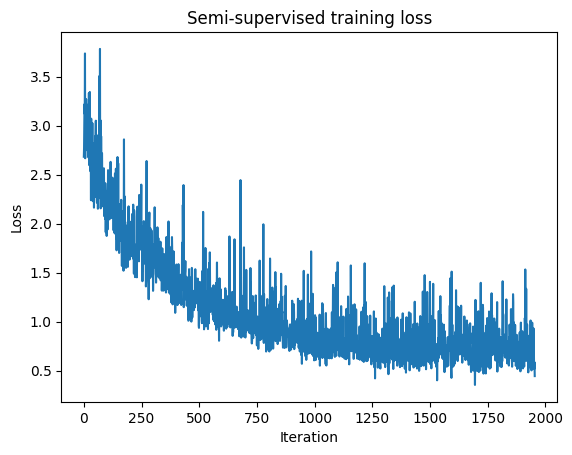

In [9]:
print(propagated_labels)
print(pseudo_labels)
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [12]:
# Evaluate the model
semi_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = semi_model_10(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the semi-supervised trained model: %d %%' % (100 * correct / total))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 4, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3,
        3, 3, 2, 3, 3, 4, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3,
        2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2,
        3, 3, 2, 3, 3, 3, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 3, 3,
        2, 3, 2, 2, 4, 2, 3, 2, 3, 2, 4, 3, 2, 2, 2, 4, 2, 2, 2, 3, 4, 2, 3, 2,
        2, 3, 4, 3, 2, 2, 4, 2], device='cuda:0')
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
        3, 3, 2, 2, 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([2, 2, 2, 4, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 4, 2, 2, 2, 2, 3,
        2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2,
        2, 3, 2, 4, 4, 2, 4, 3, 2, 2, 2, 3, 2, 3, 2, 2, 4, 2, 2, 4, 3, 2, 3, 3,
        2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 3, 2, 4, 4, 3, 3, 3, 2, 4, 3, 2, 3,
        3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 4, 3, 2, 4, 2, 2, 2, 3, 2, 2, 2, 4, 2,
        3, 3, 2, 4, 2, 3, 3, 4], device='cuda:0')
tensor([5, 0, 4, 6, 0, 6, 3, 6, 8, 1, 1, 8, 9, 7, 2, 9, 0, 2, 2, 9, 0, 6, 5, 7,
        7, 9, 1, 7, 9, 8, 4, 5, 0, 8, 0, 2, 5, 2, 1, 4, 4, 8, 9, 7, 8, 3, 6, 6,
        0, 1, 1, 1, 8, 1, 4, 4, 0, 7, 8, 2, 1, 2, 5, 4, 6, 0, 5, 7, 4, 4, 3, 9,
        5, 8, 8, 0, 8, 7, 4, 1, 8, 4, 9, 5, 4, 1, 7, 7, 7, 7, 0, 3, 8, 3, 3, 0,
        5, 7, 0, 8, 0, 0, 9, 2, 2, 3, 4, 8, 2, 2, 6, 3, 3, 6, 2, 9, 4, 0, 1, 7,
        5, 5, 7, 3, 0, 4, 2, 0], device='cuda:0')
tensor([3, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2], device='cuda:0')
tensor([7, 5, 8, 0, 8, 2, 

In [ ]:
import pickle
model_filename = 'semi_supervised_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(semi_model_10, f)

print(f"Trained model saved as '{model_filename}'")

Trained model saved as 'semi_supervised_model.pkl'
